# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


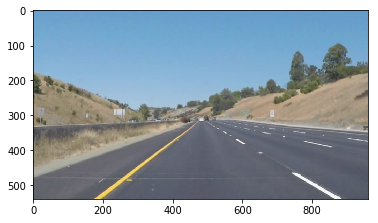

In [2]:
#reading in an image
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

True

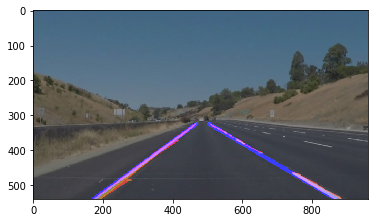

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory

#creating a grayscale image
Imagegray = grayscale(image)


kernel_size = 3
blur_image = gaussian_blur(Imagegray,kernel_size)

#Applying canny edge detection
cannyimage = canny(blur_image,100,125)
#plt.imshow(cannyimage,cmap='Greys_r')


#Finding image shape, using it to define the region of interest and then only including that region of interest
imshape = image.shape
ytoplevel = 325
Final_vertices = np.array([[(125,imshape[0]),(452, ytoplevel), (520, ytoplevel), (900,imshape[0])]], dtype=np.int32) 
masked_image = region_of_interest(cannyimage,Final_vertices)
#plt.imshow(masked_image,cmap='Greys_r')

#Applying hough transform to image
houghed_image = hough_lines(masked_image,2.5,1,16,10,80)
#plt.imshow(houghed_image)


#Adding houghed transformed image to the original image to give raw lane detected image
weighted_image = weighted_img(houghed_image,image,0.8,1.,0.)
#plt.imshow(weighted_image)

Final_image_unfilt = cv2.cvtColor(weighted_image, cv2.COLOR_BGR2RGB)

cv2.imwrite("Image_lanes_raw.jpg",Final_image_unfilt)

#Averaging line or extrapolating them
lines = cv2.HoughLinesP(masked_image, 2.5, 1, 16, np.array([]), 10, 80)
x1l=0
y1l=0
x2l=0
y2l=imshape[0]

x1r=0
y1r=imshape[0]
x2r=0
y2r=0

#Finding bottom left point of line by calculating slope of line and if less than zero calculating lowest point in y1
for line in lines:
        for x1,y1,x2,y2 in line:
            if (((y2-y1)/(x2-x1))<0):
                if (y1>=y1l):
                    x1l=x1
                    y1l=y1
                else:
                    x1l=x1l
                    y1l=y1l
            else:
                x1r=x1r
                y1r=y1r
                x2r=x2r
                y2r=y2r

#Finding top left point of line by calculating slope of line and if less than zero calculating lowest point in y2
for line in lines:
        for x1,y1,x2,y2 in line:
            if (((y2-y1)/(x2-x1))<0):
                if (y2<=y2l):
                    x2l=x2
                    y2l=y2
                else:
                    x2l=x2l
                    y2l=y2l
                    
            else:
                x1r=x1r
                y1r=y1r
                x2r=x2r
                y2r=y2r
                
#Finding top right point of line by calculating slope of line and if greater than zero calculating top most point in y1
for line in lines:    
    for x1,y1,x2,y2 in line:
        if (((y2-y1)/(x2-x1))>0):
            if (y1<=y1r):
                x1r=x1
                y1r=y1
            else:
                x1r=x1r
                y1r=y1r
        else:
            x1l=x1l
            y1l=y1l
            x2l=x2l
            y2l=y2l

#Finding bottom right point of line by calculating slope of line and if greater than zero calculating lowest point in y2
for line in lines:
        for x1,y1,x2,y2 in line:
            if (((y2-y1)/(x2-x1))>0):
                if (y2>=y2r):
                    x2r=x2
                    y2r=y2
                else:
                    x2r=x2r
                    y2r=y2r
                    
            else:
                x1l=x1l
                y1l=y1l
                x2l=x2l
                y2l=y2l             

#Now using the top and bottom points of the left and right lane, I calculate the slope and extrapolate it by finding the x axis points at the extreme top and bottom of region of interest
slopeofrightlane = ((y2r-y1r)/(x2r-x1r))
x2rnew = int(((imshape[0]-y1r)/slopeofrightlane)+x1r)
x1rnew = int(((ytoplevel-y2r)/slopeofrightlane)+x2r)

slopeofleftlane = ((y2l-y1l)/(x2l-x1l))
x2lnew = int(((imshape[0]-y1l)/slopeofleftlane)+x1l)
x1lnew = int(((ytoplevel-y2l)/slopeofleftlane)+x2l)

Lines_extended = ([[x1lnew,ytoplevel,x2lnew,imshape[0]]],
                   [[x1rnew,ytoplevel,x2rnew,imshape[0]]])

line_image = np.zeros((imshape[0], imshape[1], 3), dtype=np.uint8) 

for line in Lines_extended:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(0,0,255),10)
        

solid_line_image = cv2.addWeighted(weighted_image, 0.8, line_image, 1, 0)

plt.imshow(solid_line_image)
Final_image_filt = cv2.cvtColor(solid_line_image, cv2.COLOR_BGR2RGB)

cv2.imwrite("Final_image_solid_line.jpg",Final_image_filt)






## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
     #creating a grayscale image
    Imagegray = grayscale(image)


    kernel_size = 3
    blur_image = gaussian_blur(Imagegray,kernel_size)

    #Applying canny edge detection
    cannyimage = canny(blur_image,100,125)
    #plt.imshow(cannyimage,cmap='Greys_r')


    #Finding image shape, using it to define the region of interest and then only including that region of interest
    imshape = image.shape
    ytoplevel = 325
    Final_vertices = np.array([[(125,imshape[0]),(452, ytoplevel), (520, ytoplevel), (900,imshape[0])]], dtype=np.int32) 
    masked_image = region_of_interest(cannyimage,Final_vertices)
    #plt.imshow(masked_image,cmap='Greys_r')

    #Applying hough transform to image
    houghed_image = hough_lines(masked_image,2.5,1,16,10,80)
    #plt.imshow(houghed_image)


    #Adding houghed transformed image to the original image to give raw lane detected image
    weighted_image = weighted_img(houghed_image,image,0.8,1.,0.)
    #plt.imshow(weighted_image)

    Final_image_unfilt = cv2.cvtColor(weighted_image, cv2.COLOR_BGR2RGB)

    #cv2.imwrite("Final_image_unfiltered.jpg",Final_image_unfilt)

    #Averaging line or extrapolating them
    lines = cv2.HoughLinesP(masked_image, 2.5, 1, 16, np.array([]), 10, 80)
    #Creating initial values for left and right line's top and bottom points
    x1l=0
    y1l=0
    x2l=0
    y2l=imshape[0] #This is set as imshape[0] because it is the lowest most y axis value and I will reference off of this for initialization

    x1r=0
    y1r=imshape[0] #This is set as imshape[0] because it is the lowest most y axis value and I will reference off of this for initialization
    x2r=0
    y2r=0

    #Finding bottom left point of line by calculating slope of line and if less than zero calculating lowest point in y1
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (((y2-y1)/(x2-x1))<0):
                if (y1>=y1l):
                    x1l=x1
                    y1l=y1
                else:
                    x1l=x1l
                    y1l=y1l
            else:
                x1r=x1r
                y1r=y1r
                x2r=x2r
                y2r=y2r

    #Finding top left point of line by calculating slope of line and if less than zero calculating lowest point in y2
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (((y2-y1)/(x2-x1))<0):
                if (y2<=y2l):
                    x2l=x2
                    y2l=y2
                else:
                    x2l=x2l
                    y2l=y2l
                    
            else:
                x1r=x1r
                y1r=y1r
                x2r=x2r
                y2r=y2r
                
    #Finding top right point of line by calculating slope of line and if greater than zero calculating top most point in y1
    for line in lines:    
        for x1,y1,x2,y2 in line:
            if (((y2-y1)/(x2-x1))>0):
                if (y1<=y1r):
                    x1r=x1
                    y1r=y1
                else:
                    x1r=x1r
                    y1r=y1r
            else:
                x1l=x1l
                y1l=y1l
                x2l=x2l
                y2l=y2l

    #Finding bottom right point of line by calculating slope of line and if greater than zero calculating lowest point in y2
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (((y2-y1)/(x2-x1))>0):
                if (y2>=y2r):
                    x2r=x2
                    y2r=y2
                else:
                    x2r=x2r
                    y2r=y2r
                    
            else:
                x1l=x1l
                y1l=y1l
                x2l=x2l
                y2l=y2l
                
    #Now using the top and bottom points of the left and right lane, I calculate the slope and extrapolate it by finding the x axis points at the extreme top and bottom of region of interest            
    slopeofrightlane = ((y2r-y1r)/(x2r-x1r))
    x2rnew = int(((imshape[0]-y1r)/slopeofrightlane)+x1r)
    x1rnew = int(((ytoplevel-y2r)/slopeofrightlane)+x2r)
    
    slopeofleftlane = ((y2l-y1l)/(x2l-x1l))
    x2lnew = int(((imshape[0]-y1l)/slopeofleftlane)+x1l)
    x1lnew = int(((ytoplevel-y2l)/slopeofleftlane)+x2l)

    Lines_extended = ([[x1lnew,ytoplevel,x2lnew,imshape[0]]],
                      [[x1rnew,ytoplevel,x2rnew,imshape[0]]])

    line_image = np.zeros((imshape[0], imshape[1], 3), dtype=np.uint8) 

    for line in Lines_extended:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(0,0,255),10)
        
    
    solid_line_image = cv2.addWeighted(weighted_image, 0.8, line_image, 1, 0)
    #plt.imshow(solid_line_image)

    Final_image_filt = cv2.cvtColor(solid_line_image, cv2.COLOR_BGR2RGB)
    #plt.imshow(solid_line_image)

    #cv2.imwrite("Final_image_solid_line.jpg",Final_image_filt)
    result = solid_line_image
    return result

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:05<00:00, 39.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.9 s, sys: 1.3 s, total: 4.2 s
Wall time: 6.25 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [441]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:17<00:00, 39.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 8.83 s, sys: 4.35 s, total: 13.2 s
Wall time: 17.9 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


Reflection of my project:
The pipeline is created such that it first finds the edges by using guassian smoothing and canny edge detection by using the available functions. After that I created a mask to only include the area of interest of a quadilateral shape by using the region of interest function. I put in the points for the region of interest by tuning the points to where I feel the region of interest would be best suitable and to avoid any unnecesary detections from outside the lanes. I then applied a hough transform to get the lines of the image by tuning the available parameters. I did this by making sure all the lanes were detected so setting a moderate value for threshold i.e. number of pixels that make a line and also focused on the maximum gap between lines so that I have better connection between lane segments within each line.

To create the solid lines I used the cv2.houghlinesP function to determine the various lines in the image. Using the information of the lines end points, I calculated the slope of each line and figured out which of the line arrays are the left and which are the right and while finding that I used for loops to find the top most and bottom most points of the left and right lanes that was calculated from the hough transform. By doing this I was able to average off the line. Now the problem with this was that even if I joined the lines they could not cover the entire length of the road if a segment is missing at the bottom or top of the lanes so to do this I calculated the slopes with the extreme points of the left and right lane used them to caluclate the x axis positions for the extreme positions of my region of interst. By doing this I was able to extrapolate the lines. Thus you get a nice smooth solid line. 

Please note: That my image pipeline saves two images one image will have the lanes detected roughly and the other will be an image with the solid lines (blue) and the red lines below it being the roughly detected lines. The video part will only create one intended video i.e. the blue lane with the red rough lines below it.

My end result shows the solid line (blue line) with the raw lane lines (red line) underneath it. 

I could make it more robust by tuning the hough transform even more and may be run the hough transform for the left lane and right lane separately so in a way tune them accordingly as roads are not always stratight and this could account for curved lines too. I could also make it robust by setting a particular length for each lane so that the side yellow dips in the side yellow lanes don't get detected, I could do this by discarding line smaller than a certain length or discarding detections in an internal area.

My current pipeline will likely fail on a curved road as my region of interest is quadilateral and not a curved area.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))